In [29]:
import numpy as np
import json
import matplotlib.pyplot as plt
import covid_funs
import importlib
import subprocess
import sys
import shlex

In [30]:
#from https://www.endpoint.com/blog/2015/01/28/getting-realtime-output-using-python
def run_command(command):
    process = subprocess.Popen(shlex.split(command), stdout=subprocess.PIPE, stderr = subprocess.STDOUT, text = False)
    outlist = []
    while True:
        output = process.stdout.readline()
        outlist += [output]
        if output.decode("utf-8") == '' and process.poll() is not None:
            break
        if output:
            if '\r' in output.decode("utf-8"):
                
                sys.stdout.write('\r' + output.decode("utf-8").strip())
            else:
                sys.stdout.write(output.decode("utf-8"))
    rc = process.poll()
    return rc,outlist

In [126]:
importlib.reload(covid_funs)

<module 'covid_funs' from '/Users/m197894/Documents/COVID_Model/disease_net/covid_funs.py'>

We can generate a simulated outbreak using the SIR model. We also give sampling bias and capacity. If capacity is given as a list, samples will be later generated for each capacity in the list. Capacity can also be given as a list (implying max capacities) and a function (which should take values from 0 to 1) for time-varying capacty. For this, pass the function as a keyword argument capacityfun to gen_jsons.

In [19]:
Bias = 1 #Bias = 1 means no bias. Higher puts bias towards testing symptomatic individuals.
capacities = [100,500,1000,2500,5000]

def SIR_model(t,X,params):
    s,i,r= X
    beta,recrate = params
    if callable(beta):
        dsdt = -(beta(s,i,r,t))*s*i
    else:
        dsdt = -beta*s*i
    didt = -dsdt - recrate*i
    drdt = recrate*i
    return [dsdt,didt,drdt]

timescale = 15 #1/gamma


init_inf = 0.01

s0 = (1-init_inf)
i0 = init_inf
r0 = 0

R0 = 2.2

end_time = 200

dynamics = covid_funs.gen_jsons(end_time,[s0,i0,r0],SIR_model,1,-1,[0,2],[R0/timescale,1/timescale],Bias,capacities)

In [16]:
dynamics.keys()

dict_keys(['TimePoints', 'Symptomatic', 'Asymptomatic', 'NonInfected'])

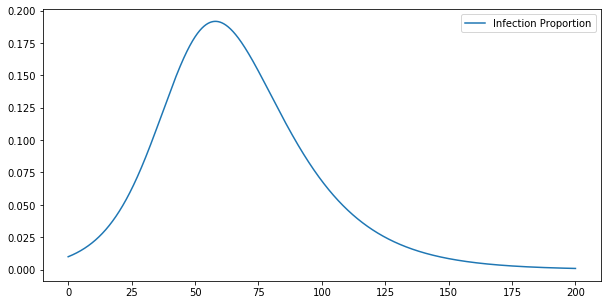

In [36]:
total_infected = np.array(dynamics['Symptomatic']) + np.array(dynamics['Asymptomatic'])

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(dynamics["TimePoints"],total_infected, label = "Infection Proportion")

ax.legend()

We use a .go executible to generate simulated sampling.

In [158]:
svfl = "json_io/sample_sims.json"
dynamicsfl = "json_io/dynamics.json"
biasfl = "json_io/bias.json"
capfl = "json_io/capacity.json"
num_trials = 10
falsePos = 0
falseNeg = 0

base_command = "./disease_confidence"
opts = ["-Dynamics="+dynamicsfl]
opts +=["-TestingBias="+biasfl]
opts +=["-TestingCapacities="+capfl]
opts +=["-Trials="+str(num_trials)]
opts +=["-SaveFile="+svfl]
opts +=["-FalsePositive="+str(falsePos)]
opts +=["-FalseNegative="+str(falseNeg)]


full_command = base_command + " " + " ".join(opts)
so = run_command(full_command)

And load the results from that executible into a dict keyed by max sample/day.

In [171]:
with open(svfl) as fl:
    samples = json.load(fl)

In [172]:
samples["100"][0].keys()

dict_keys(['DailyPositive', 'DailyTotal', 'DayTimes'])

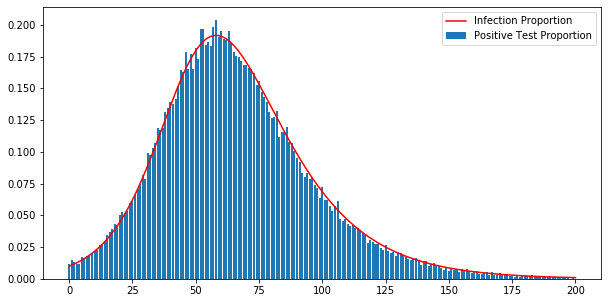

In [181]:
pos_prop = np.array(samples["5000"][0]["DailyPositive"])/np.array(samples["5000"][0]["DailyTotal"])

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(dynamics["TimePoints"],total_infected, label = "Infection Proportion", color = 'red')
ax.bar(samples["5000"][0]["DayTimes"],pos_prop, label = "Positive Test Proportion")

ax.legend()

In [182]:
performance = {}
for ky,val in samples.items():
    performance[ky]=[covid_funs.judge_peaks(covid_funs.findPeak_smth,dynamics,v,smoothing = 5) for v in val]

In [175]:
found_prob = {}
for ky,val in performance.items():
    found_prob[ky] = sum([pk["Found"] for dyn in val for  pk in dyn[0].values()])/sum([len(v[0]) for v in val])

In [176]:
false_pos = {}
for ky,val in performance.items():
    false_pos[ky] = 1-sum([pk["Real"] for dyn in val for  pk in dyn[1].values()])/sum([len(v[1]) for v in val])

In [177]:
found_prob

{'100': 0.6, '1000': 0.6, '2500': 0.6, '500': 0.7, '5000': 0.8}

In [178]:
false_pos

{'100': 0.9754768392370572,
 '1000': 0.9626865671641791,
 '2500': 0.9617834394904459,
 '500': 0.9777777777777777,
 '5000': 0.9038461538461539}

In [179]:
mean_sq_error = {}
for ky,val in performance.items():
    mean_sq_error[ky] =[(sum([pk["SqDist"] for pk in dyn[1].values()])/len(dyn[1]))**(1/2) for dyn in val]

In [180]:
mean_sq_error

{'100': [70.00491264274174,
  63.83161812905248,
  64.20889277790823,
  52.744227777358944,
  65.46762418992598,
  66.68884839311758,
  66.31540586889149,
  66.4756798649985,
  66.53815128874061,
  59.705604147909376],
 '1000': [80.18872530890475,
  75.44311346680688,
  78.84733667030449,
  70.16311861858709,
  79.02115223154074,
  80.0782160254492,
  80.71250935677203,
  82.63821702937132,
  79.43903443715818,
  67.54125591074127],
 '2500': [72.833388634611,
  94.28560456015094,
  91.2961983509378,
  94.09431438721727,
  76.58692773574565,
  86.68660095836421,
  78.88146698264227,
  85.47208608663065,
  86.00334134336076,
  86.01276794755726],
 '500': [71.53185042343233,
  75.75973193431278,
  76.00844414327496,
  79.47431117262971,
  75.68997621878545,
  77.38903807572493,
  73.04049023853817,
  70.6246120933318,
  78.9044292268389,
  73.6387615721683],
 '5000': [92.73053704147529,
  93.58222731497268,
  90.39733126591952,
  81.15755766819876,
  87.25382382868757,
  90.7055814159216,